In [1]:
!pip install -Uqq fastbook
# !pip install nbdev

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

## Gathering data

In [27]:
# search_images_ddg: func of fastbook/__init__.py
# ??search_images_ddg
#
# fastdownload/core.py
doc(download_url)

In [7]:
imgs = search_images_ddg('grizzly bear')
len(imgs)

200

In [11]:
dest = 'data/bears/grizzly.jpg'
download_url(imgs[0], dest=dest)

Path('bears/grizzly.jpg')

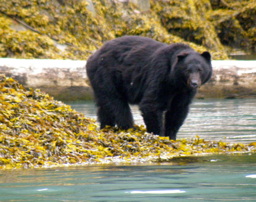

In [15]:
img = Image.open(dest)
img.to_thumb(256)

In [3]:
bear_types = 'grizzly','black','teddy'
path = Path('data/bears')

In [20]:
for t in bear_types:
    dest = (path/t)
    Path.mkdir(dest, exist_ok=True)
    print(f'Search {t} bears')
    urls = search_images_ddg(f'{t} bear')
    download_images(dest=dest, urls=urls)

Search grizzly bears
Search black bears
Search teddy bears


In [8]:
img_files = get_image_files(path)

In [9]:
failed = verify_images(img_files)
failed

In [10]:
failed.map(Path.unlink)

## Train model

In [29]:
doc(DataBlock)

In [4]:
bears = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(128),
)

In [ ]:
dls = bears.dataloaders(path, device='cpu')
dls.valid.show_batch(max_n=4, nrows=1)

/Users/hatruong/miniforge3/lib/python3.10/site-packages/fastai/data/transforms.py:225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(col):


In [ ]:
# try another item transform
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path, device='cpu')
dls.valid.show_batch(max_n=4, nrows=1)

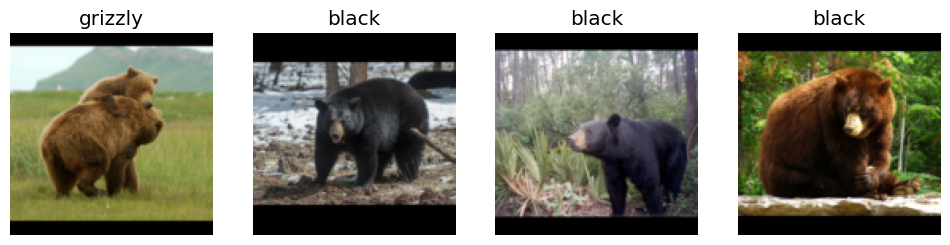

In [7]:
# try another item transform
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode=PadMode.Zeros))
dls = bears.dataloaders(path, device='cpu')
dls.valid.show_batch(max_n=4, nrows=1)

In [8]:
# try another item transform
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path, device='cpu')
dls.valid.show_batch(max_n=4, nrows=1)

### Data Augument

In [51]:
??aug_transforms

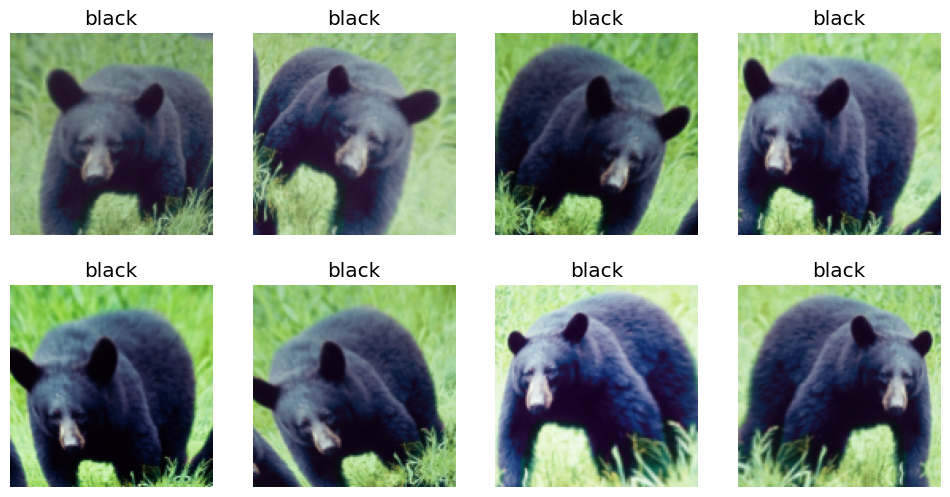

In [53]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path, device='cpu')
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Train model

In [56]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path, device='cpu')

In [59]:
from fastai.vision import learner
stats = learner.model_meta.get(resnet18, learner._default_meta).get('stats')
print('orginal stats:', stats)
learner.model_meta[resnet18]["stats"] = learner.model_meta[resnet18]["stats"] + (1, 4, False,)
# learner.model_meta[resnet18]["stats"] = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 1, 4, False)
print('after update:', learner.model_meta[resnet18].get('stats'))

orginal stats: ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
after update: {'cut': -2, 'split': <function _resnet_split at 0x170f5f7f0>, 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 1, 4, False)}


In [69]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(4)

### Check the confusion matrix

In [70]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [71]:
# show incorrect items
interp.plot_top_losses(5, nrows=3)

### Correct data

In [68]:
#hide_output
cleaner = ImageClassifierCleaner(learner)
cleaner

## Turn model to application

In [ ]:
model_path = 'bear_detection.pkl'

In [72]:
learner.export('bear_detection.pkl')

## Prediction

In [3]:
# fastai/learner.py
# ??load_learner

In [4]:
predictor = load_learner(Path(model_path))

In [6]:
print(predictor.dls.vocab)

In [74]:
labels = learner.dls.vocab
labels
def predict(img):
    img = PILImage.create(img)
    pred, pred_idx, probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [75]:
labels

In [ ]:
test